In [35]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [36]:
import numpy as np
import pandas as pd
import glob

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
def scatter_plt(
    data, x_var, y_var, flag_color, colors=['darkolivegreen','firebrick'], x_log=True
    , n_sample=None, smooth=False, frac=0.1, seed=123):
    """
    Scatter plot (x with log10)
    Param:
        - flag_color: name of binary variable to color points with
        - n_sample: size of sample or None
        - lowess: plot smooth curve or not
        - frac: lowess frac
    """
    if n_sample:
        data = data.sample(n_sample, random_state=seed)
    data_resto = data
    if flag_color:
        data_flag = data[data[flag_color] == 1]
        data_resto = data[data[flag_color] == 0]
    fig, ax = plt.subplots()
    if x_log:
        ax.set_xscale('log')
        ax.set_xlim(left=10, right=10**8)
    plt.scatter(x_var, y_var, linewidth=0, c=colors[0], s=4, data=data_resto)
    if flag_color:
        plt.scatter(x_var, y_var, linewidth=0, c=colors[1], s=30, data=data_flag)
    if smooth:
        x_data = data[x_var]
        if x_log:
            x_data = np.log10(data[x_var])
        smooth_data = lowess(data[y_var], x_data, frac=frac)
        x_smooth = smooth_data[:,0]
        if x_log:
            x_smooth = 10**smooth_data[:,0]
        line = ax.plot(
            x_smooth, smooth_data[:,1], color='black', lw=1.0, ls='--')
    ax.axhline(0, ls='--', color='gray', linewidth=0.5)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    return fig, ax


def boxplots_plt(data, x_var, y_var, bins, flag_points=None):
    """
    Cut x_var in bins and make one boxplot per bin
    Param:
        - flag_points: name of flag of points to plot
    """
    #data = data.sort_values("freq") # ordena por freq para pintar scatter rojo correctamente
    freq_bins = pd.cut(np.log10(data[x_var]), bins=bins)
    nobs = freq_bins.value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=freq_bins, y=data[y_var], showfliers=False)
    if flag_points:
        is_flag = data[flag_points] == 1
        bins_flag = freq_bins[is_flag]
        bins_flag_rank = stats.rankdata(bins_flag, method='max') - 1
        y_flag = data[y_var][is_flag]
        plt.scatter(
            bins_flag_rank, y_flag, linewidth=0, c='firebrick', s=40)
    ax.axhline(0, ls='--', color='black', linewidth=0.5)
    labels_ypos = ax.get_ylim()[1] + .005
    for i in range(len(nobs)):
        ax.text(
            i, labels_ypos, nobs[i], horizontalalignment='center', size='small'
            , color='black', weight='semibold')
    return fig, ax


def boxplots_and_scatter_plt(df_list, x_var, y_var, bins=[1,2,3,4,5,6,8]):
    """
    plot only new words over boxplot
    Boxplots are built with data of all df_list
    """
    # Boxplot
    data = pd.concat(df_list)
    freq_bins = pd.cut(np.log10(data[x_var]), bins=bins)
    nobs = freq_bins.value_counts().values / len(df_list)
    nobs = [str(int(x)) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    fig, ax = plt.subplots()
    ax.axhline(0, ls='-', color='black', linewidth=0.5)
    ax = sns.boxplot(
        x=freq_bins, y=data[y_var], showfliers=False, color="white", boxprops=dict(alpha=.3))
    # lines and dots
    for i in range(len(df_list)):
        data_nw = df_list[i].query("newword == 1")
        y_nw = data_nw[y_var]        
        bins_nw = pd.cut(np.log10(data_nw[x_var]), bins=bins)
        bins_nw_rank = stats.rankdata(bins_nw, method='max') - 1
        plt.plot(bins_nw_rank, y_nw, color='gray', lw=1.0, ls='--')
        plt.scatter(bins_nw_rank, y_nw, linewidth=0.1, c='firebrick', s=30)
        # n labels
    labels_ypos = ax.get_ylim()[1] + .005
    for i in range(len(nobs)):
        ax.text(
            i, labels_ypos, nobs[i], horizontalalignment='center', size='small'
            , color='black', weight='semibold')
    return fig, ax

#    ax.set_xscale('log')
#    ax.set_xlim(left=10, right=10**8)
#    ylims = np.quantile(df_list[0][y_var], [.001, .999]).tolist()
#    ax.set_ylim(ylims)
#    # plt.scatter(x_var, y_var, linewidth=0, c='white', s=1, data=df_list[0]) # para setear ylim con 1er dataset
#    ax.axhline(0, ls='--', color='gray', linewidth=0.5)
#    plt.xlabel(x_var)
#    plt.ylabel(y_var)

In [38]:
NEWWORDS = ['c'+str(i) for i in range(1,7)] # new context words

## Data

Usamos los sesgos calculados en 5 corpus -- en cada uno de ellos se agregaron 6 palabras de contexto al azar con diferentes órdenes de frecuencia y 2 palabras target con frecuencias similares a _he_ y _she_. 

In [39]:
# Check que son dframes distintos a Window=5
#aa = pd.read_csv("results/csv/biasbyword_full-C4_HE-SHE.csv")
#bb = pd.read_csv("results/csv/window_10/biasbyword_full-C4_HE-SHE.csv")
#
#print(
#    aa['diff_cosine_ppmi'].head()
#      ,bb['diff_cosine_ppmi'].head()
#)
    #dfs_heshe[0].query("word == 'the'") # da Okkkk!!!!!

In [40]:
# Check que son dframes distintos a Window=5
#aa = pd.read_csv("results/csv/biasbyword_full-C4_HE-SHE.csv")
#bb = pd.read_csv("results/csv/window_10/biasbyword_full-C4_HE-SHE.csv")
#

In [41]:
#print(
#    aa[['pmi_a']].head() - bb[['pmi_a']].head()
#)
#    #dfs_heshe[0].query("word == 'the'") # da Okkkk!!!!!

In [42]:
# corpus ids of newwords corpora: 4,5,6,7,8
files_t1t2 = glob.glob("results/csv/window_10/biasbyword_full-C[4-8]_T1-T2.csv")
files_heshe = glob.glob("results/csv/window_10/biasbyword_full-C[4-8]_HE-SHE.csv")

In [43]:
%%time
# read
dfs_t1t2 = [pd.read_csv(f) for f in files_t1t2]
dfs_heshe = [pd.read_csv(f) for f in files_heshe]

Wall time: 31.7 s


In [44]:
# flag de new word
for df in dfs_t1t2:
    df['newword'] = np.where(df['word'].isin(NEWWORDS), 1, 0)

for df in dfs_heshe:
    df['newword'] = np.where(df['word'].isin(NEWWORDS), 1, 0)    

## Plots

Para cada sesgo (T1/T2 y He/she) y cada métrica de sesgo (w2v, glove, ppmi y ppmi_vec) grafico:

* Boxplots con la distribución del sesgo para cada orden de frecuencia en los 5 corpora en simultáneo
* Puntos que indican el sesgo de las palabras ficticias de contexto -- las líneas que los unen indican pertenencia a un mismo corpus

### Sesgo HE/SHE

**word2vec**

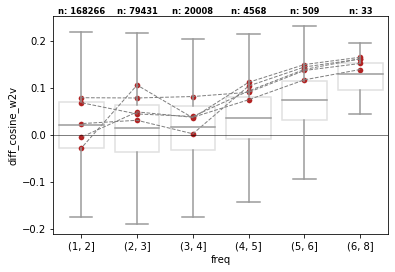

In [45]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_heshe, 'freq', 'diff_cosine_w2v')

El sesgo promedio crece con la frecuencia

**GloVe**

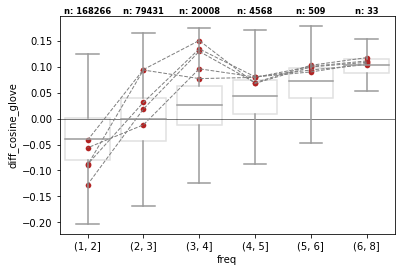

In [46]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_heshe, 'freq', 'diff_cosine_glove')

El sesgo promedio crece con la frecuencia

**DPPMI**

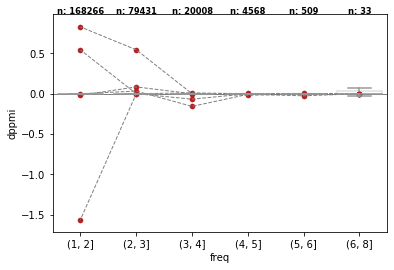

In [47]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_heshe, 'freq', 'dppmi')

**PPMI vec**

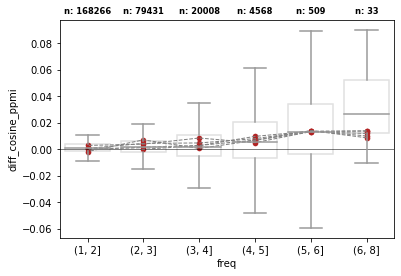

In [48]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_heshe, 'freq', 'diff_cosine_ppmi')

**Correlaciones**

Queremos ver si en las palabras ficticias correlaciona el sesgo medido con WE con el medido con PPMI_vec -- es decir, si PPMI_vec puede estar influyendo en las métricas de sesgo como hipotetizamos

In [49]:
def corr_newwords(df_list, x_var, y_var):
    #data
    df_nw = pd.concat(
        [df.query("newword == 1") for df in df_list]
        , keys=range(len(dfs_heshe))).reset_index()
    df_nw.rename(columns={"level_0": "corpus"}, inplace=True)
    df_nw['corpus'] = df_nw['corpus'].astype("category")
    # scatter
    #for i in range(len(dfs_heshe)):
    #    df_ = df_nw.query("corpus == @i")
    #    plt.scatter(x=x_var, y=y_var, data=df_, s=12)
    #fig, ax = plt.subplots()
    sns.lmplot(
        x=x_var, y=y_var, hue="corpus", data=df_nw, ci=None)
    #plt.xlim(-0.005, 0.01)
    return None
    #plt.legend(loc='lower right', ncol=6)    

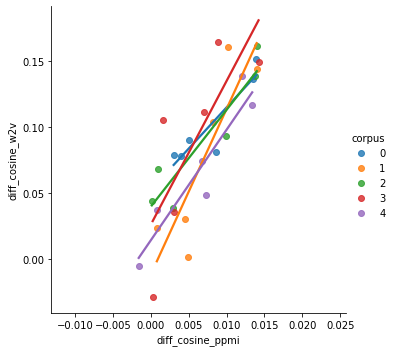

In [50]:
corr_newwords(dfs_heshe, "diff_cosine_ppmi", "diff_cosine_w2v")


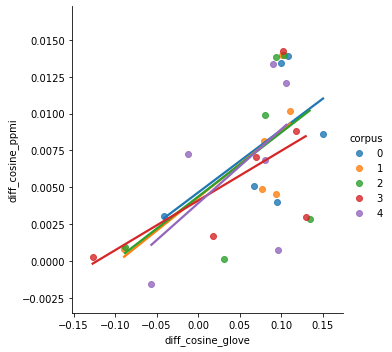

In [51]:
corr_newwords(dfs_heshe, "diff_cosine_glove", "diff_cosine_ppmi")

### Sesgo T1/T2

**word2vec**

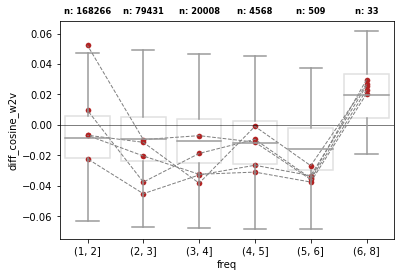

In [52]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_t1t2, 'freq', 'diff_cosine_w2v')

**GloVe**

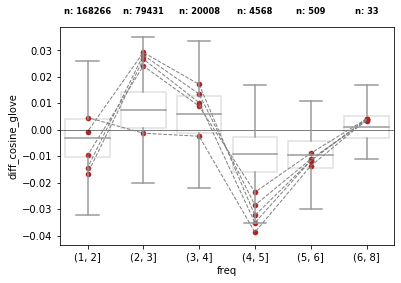

In [53]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_t1t2, 'freq', 'diff_cosine_glove')

Se rompe todo

**DPPMI**

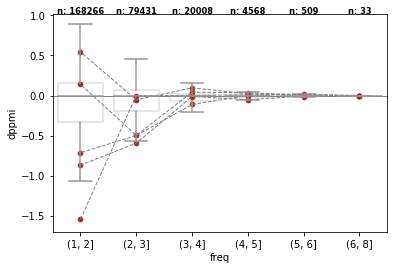

In [54]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_t1t2, 'freq', 'dppmi')

**PPMI vec**

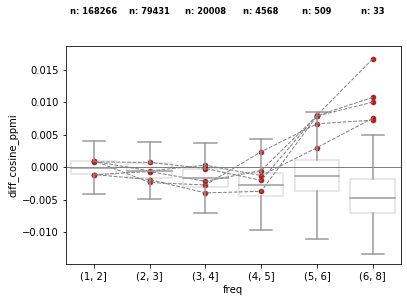

In [55]:
fig_, ax_ = boxplots_and_scatter_plt(dfs_t1t2, 'freq', 'diff_cosine_ppmi')

**Correlaciones**

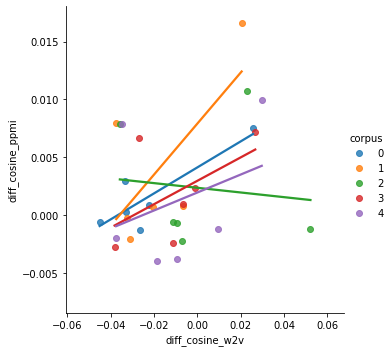

In [56]:
corr_newwords(dfs_t1t2, "diff_cosine_w2v", "diff_cosine_ppmi")

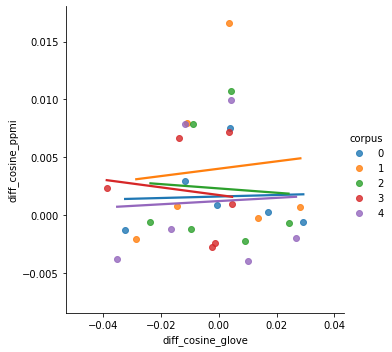

In [57]:
corr_newwords(dfs_t1t2, "diff_cosine_glove", "diff_cosine_ppmi")

---------------------------------

---------------------------------

En esta parte hay gráficos de resultados de un solo corpus, solo como chequeo

### Sesgo T1/T2

**word2vec**

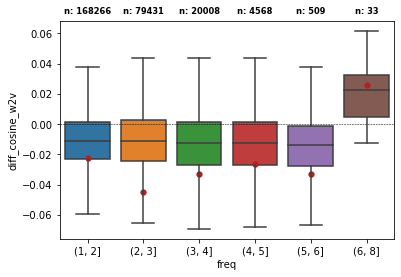

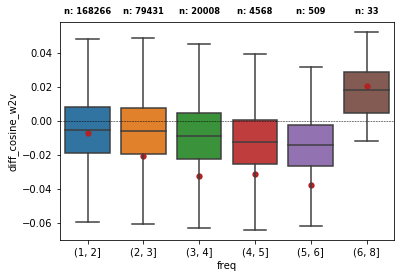

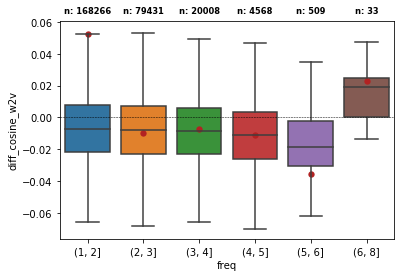

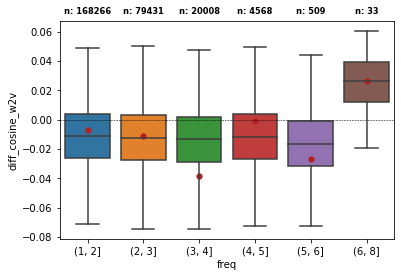

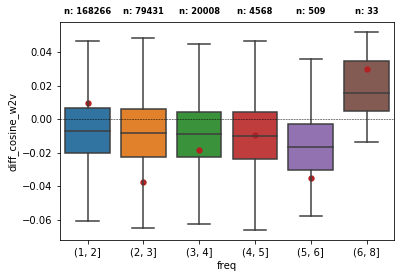

In [58]:
#fig_, ax_ = scatter_plt(
#    dfs_t1t2[0], x_var='freq', y_var='diff_cosine_w2v', flag_color="newword")
for i in range(5):
    fig_, ax_ = boxplots_plt(
        dfs_t1t2[i], x_var='freq', y_var='diff_cosine_w2v', bins=[1,2,3,4,5,6,8], flag_points="newword")

**GloVe**

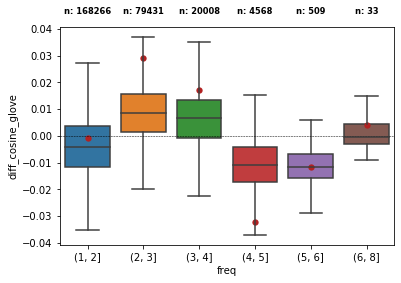

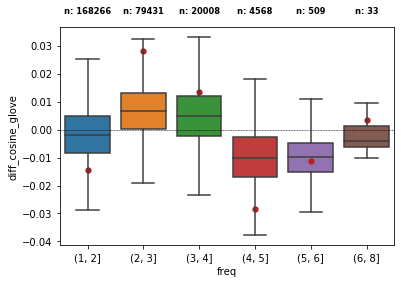

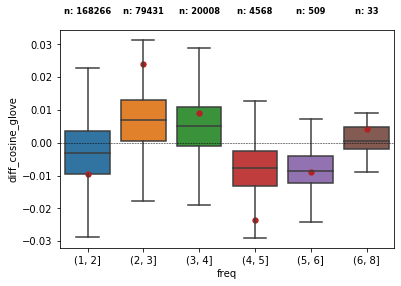

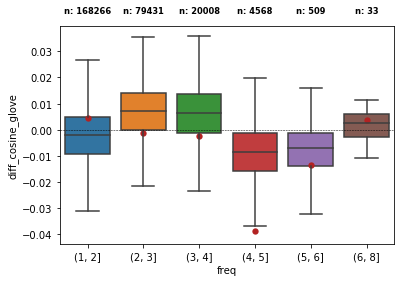

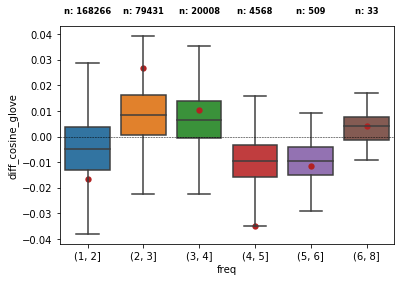

In [59]:
#fig_, ax_ = scatter_plt(
#    dfs_t1t2[0], x_var='freq', y_var='diff_cosine_glove', flag_color="newword")
#fig_, ax_ = boxplots_plt(
#    dfs_t1t2[0], x_var='freq', y_var='diff_cosine_glove', bins=[1,2,3,4,5,6,8], flag_points="newword")

for i in range(5):
    fig_, ax_ = boxplots_plt(
        dfs_t1t2[i], x_var='freq', y_var='diff_cosine_glove', bins=[1,2,3,4,5,6,8], flag_points="newword")

**PPMI vec**

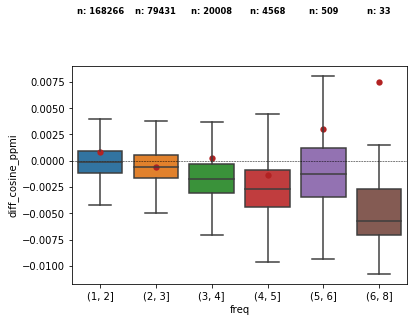

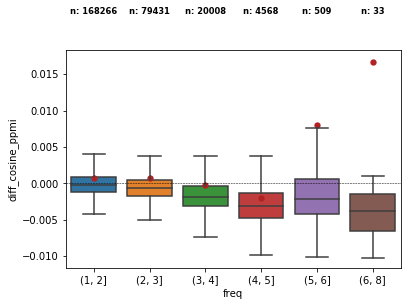

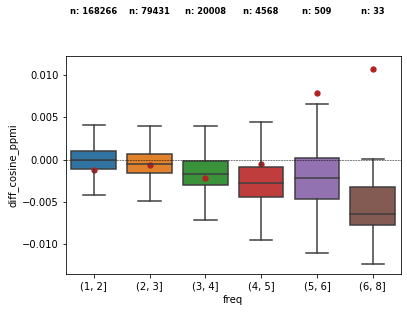

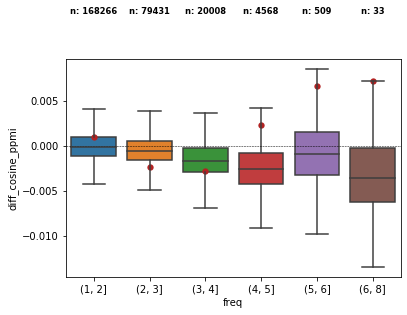

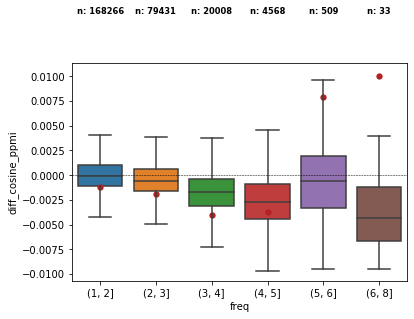

In [60]:
#fig_, ax_ = scatter_plt(
#    dfs_t1t2[0], x_var='freq', y_var='diff_cosine_ppmi', flag_color="newword")
#fig_, ax_ = boxplots_plt(
#    dfs_t1t2[0], x_var='freq', y_var='diff_cosine_ppmi', bins=[1,2,3,4,5,6,8], flag_points="newword")

for i in range(5):
    fig_, ax_ = boxplots_plt(
        dfs_t1t2[i], x_var='freq', y_var='diff_cosine_ppmi', bins=[1,2,3,4,5,6,8], flag_points="newword")

In [79]:
# chequeo calculo cosine ppmi
print(
    dfs_t1t2[0].query("word in ['he','she']")[['cosine_a_ppmi','cosine_b_ppmi']]
    ,"\n\n"
    ,dfs_heshe[0].query("word in ['t1','t2']")[['cosine_a_ppmi','cosine_b_ppmi']]
)
### da ok!!

    cosine_a_ppmi  cosine_b_ppmi
15       0.198699       0.204597
64       0.187988       0.192543 

     cosine_a_ppmi  cosine_b_ppmi
16       0.198699       0.187988
64       0.204597       0.192543


**DPPMI** (Resultados en un solo corpus)

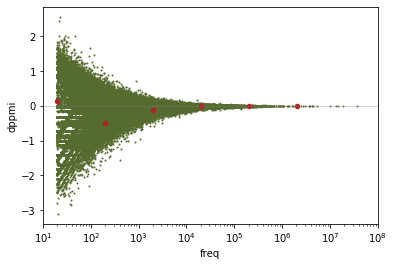

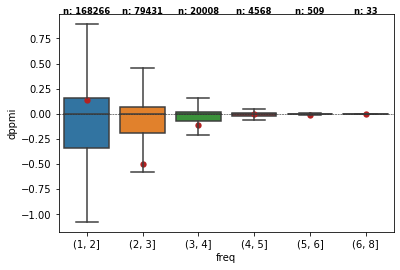

In [61]:
fig_, ax_ = scatter_plt(
    dfs_t1t2[0], x_var='freq', y_var='dppmi', flag_color="newword")
fig_, ax_ = boxplots_plt(
    dfs_t1t2[0], x_var='freq', y_var='dppmi', bins=[1,2,3,4,5,6,8], flag_points="newword")

### Sesgo HE/SHE

**word2vec** (Resultados en un solo corpus)

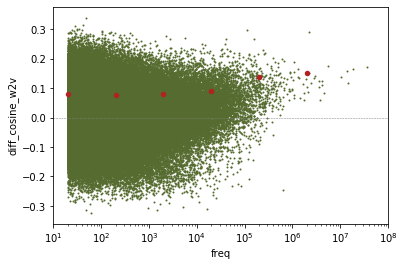

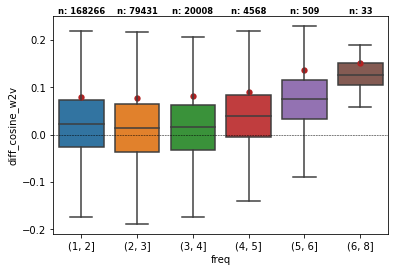

In [62]:
fig_, ax_ = scatter_plt(
    dfs_heshe[0], x_var='freq', y_var='diff_cosine_w2v', flag_color="newword")
fig_, ax_ = boxplots_plt(
    dfs_heshe[0], x_var='freq', y_var='diff_cosine_w2v', bins=[1,2,3,4,5,6,8], flag_points="newword")

**GloVe** (Resultados en un solo corpus)

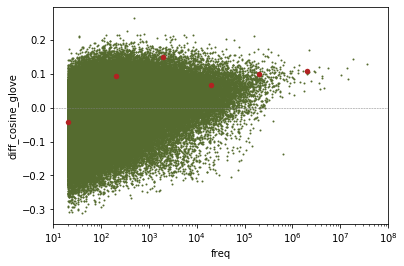

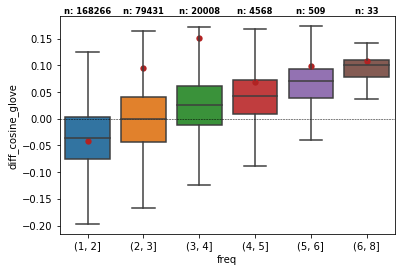

In [63]:
fig_, ax_ = scatter_plt(
    dfs_heshe[0], x_var='freq', y_var='diff_cosine_glove', flag_color="newword")
fig_, ax_ = boxplots_plt(
    dfs_heshe[0], x_var='freq', y_var='diff_cosine_glove', bins=[1,2,3,4,5,6,8], flag_points="newword")

**DPPMI** (Resultados en un solo corpus)

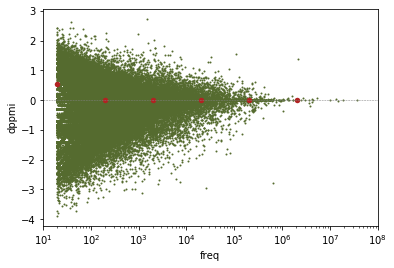

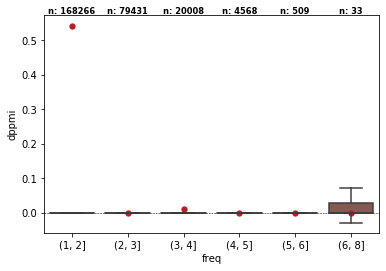

In [64]:
fig_, ax_ = scatter_plt(
    dfs_heshe[0], x_var='freq', y_var='dppmi', flag_color="newword")
fig_, ax_ = boxplots_plt(
    dfs_heshe[0], x_var='freq', y_var='dppmi', bins=[1,2,3,4,5,6,8], flag_points="newword")

**PPMI vec** (Resultados en un solo corpus)

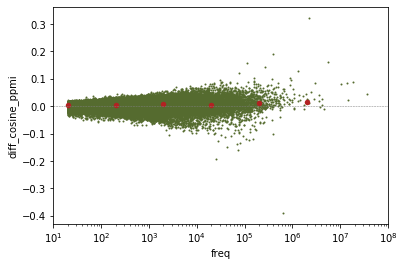

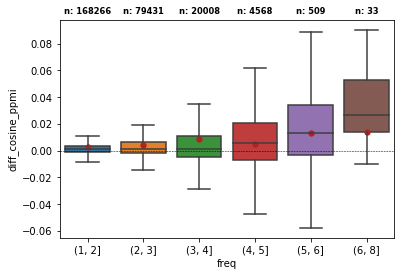

In [65]:
fig_, ax_ = scatter_plt(
    dfs_heshe[0], x_var='freq', y_var='diff_cosine_ppmi', flag_color="newword")
fig_, ax_ = boxplots_plt(
    dfs_heshe[0], x_var='freq', y_var='diff_cosine_ppmi', bins=[1,2,3,4,5,6,8], flag_points="newword")

In [66]:
# #### CHECK: newwords caen en los bins de freq correctos
# df_tmp = pd.concat([df.query("newword == 1") for df in dfs_t1t2])
# df_tmp['bin_freq'] = pd.cut(np.log10(df_tmp['freq']), bins=[1,2,3,4,5,6,8])
# df_tmp[['word','bin_freq']].sort_values("word")
# ###